In [4]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [96]:
LEMNISCATE = "l"
ELLIPSE = "e"

In [ ]:
def get_lemniscate_radius(distances):
    return np.exp(np.mean(np.log(distances)))

def get_ellipse_radius(distances):
    return np.mean(distances)

def get_radius(distances, mode):
    if mode == LEMNISCATE:
        return get_lemniscate_radius(distances)
    if mode == ELLIPSE:
        return get_ellipse_radius(distances)

In [79]:
def step1_init(points, mode):
    z1 = np.mean(points, axis=0)
    distances = np.linalg.norm(points - z1, axis=1)
    R = get_radius(distances, mode)
    return z1, R

In [80]:
def error_function_single_focus(params, points):
    z1_x, z1_y, R = params
    z1 = np.array([z1_x, z1_y])
    distances = np.linalg.norm(points - z1, axis=1)
    L = distances - R
    F = np.sum(L**2)
    return F

In [81]:
def step2_optimize(z1, R, points):
    initial_params = np.hstack((z1, R))
    result = minimize(error_function_single_focus, initial_params, args=(points,), method='BFGS')
    error = result.fun
    z1 = result.x[:2]
    R = result.x[2]
    print(result)
    return z1,R, error

In [97]:
def error_function_multi_focus(params, points, N, mode):
    foci = params[:-1].reshape(N, 2)
    R = params[-1]
    distances = np.linalg.norm(points[:, np.newaxis, :] - foci, axis=2)
    
    product_distances = np.prod(distances, axis=1) if mode == LEMNISCATE else np.sum(distances, axis=1)
    L = product_distances - R
    F = np.sum(L**2)
    return F

In [83]:
def step3_multiply_foci(foci, R, mode):
    foci.extend(foci.copy())  
    R=R**2 if mode == LEMNISCATE else R*2
    return foci, R
    

In [84]:
def step4_move_foci(foci, R, mode):
    delta = 0.1  # Small constant for movement
    N = len(foci)
    foci_array = np.array(foci)

    for idx in range(N):
        min_error = None
        best_move = None
        directions = [np.array([delta, 0]), np.array([-delta, 0]), np.array([0, delta]), np.array([0, -delta])]
        for direction in directions:
            temp_foci = foci_array.copy()
            temp_foci[idx] += direction
            params = np.hstack((temp_foci.flatten(), R))
            error = error_function_multi_focus(params, points, N, mode)
            if min_error is None or error < min_error:
                min_error = error
                best_move = direction
        foci_array[idx] += best_move
    distances = np.linalg.norm(points[:, np.newaxis, :] - foci_array, axis=2)
    product_distances = np.prod(distances, axis=1)
    R = np.exp(np.mean(np.log(product_distances)))
    return foci_array, R

In [85]:
def step5_optimize(foci, R):
    N = len(foci)
    initial_params = np.hstack((foci.flatten(), R))
    result = minimize(error_function_multi_focus, initial_params, args=(points, N), method='BFGS')
    optimized_params = result.x
    foci = optimized_params[:-1].reshape(N, 2)
    R = optimized_params[-1]
    foci = [foci[i] for i in range(N)]
    total_error = result.fun
    return foci, R, total_error

In [92]:


def plot_state(points, foci, R):
    foci = np.array(foci)
    print(R, foci)
    # Create the plot
    x_coords = points[:, 0]
    y_coords = points[:, 1]

    plt.figure(figsize=(8, 6))
    plt.scatter(x_coords, y_coords, color='blue', marker='o', label='Data Points')
    plt.scatter(foci[:, 0], foci[:, 1], color='red', marker='x', s=100, label='Foci')
    
    
    # Create a grid for plotting the lemniscate curve
    grid_size = 500
    x_min, x_max = foci[:, 0].min() - 1, foci[:, 0].max() + 1
    y_min, y_max = foci[:, 1].min() - 1, foci[:, 1].max() + 1
    
    print(x_min, x_max)
    print(y_min, y_max)
    x_grid, y_grid = np.meshgrid(
        np.linspace(x_min, x_max, grid_size),
        np.linspace(y_min, y_max, grid_size)
    )
    
    # Compute the ellipsoid values on the grid
    z_values = ellipse_function(x_grid, y_grid, foci, R)

    # Plot the lemniscate curve
    plt.contour(x_grid, y_grid, z_values, levels=[0], colors='red', linewidths=2, label='Lemniscate Curve')


    # Add labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Visualization of Initial Set of Points, Initial Center, and Initial Circle')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.axis('equal')  # Equal scaling for both axes

    # Display the plot
    plt.show()

In [93]:
def approximate_lemniscate(points, max_iterations=10, tolerance=1e-6):
    # Step 1: Initial focus and radius
    z1, R = step1_init(points)
    print("init")
    plot_state(points, [z1], R)
    # Step 2: Optimize initial focus and radius
    z1, R, error = step2_optimize(z1, R, points)
    
    # Initialize foci
    foci = [z1]
    print("optimize")
    plot_state(points, foci, R)
    
    for iteration in range(max_iterations):
        # Step 3: Double the foci
        foci, R = step3_multiply_foci(foci, R)
        
        print(f"multiply {iteration}")
        plot_state(points, foci, R)
    
        # Step 4: Foci motion step
        foci, R = step4_move_foci(foci, R)
        
        print(f"move {iteration}")
        plot_state(points, foci, R)
        
        # Step 5: Optimize parameters
        foci, R, total_error = step5_optimize(foci, R)
        
        print(f"optimize: {iteration}")
        print(f"total_error: {total_error}")
        plot_state(points, foci, R)
        
        # Step 6: Check for convergence
        if total_error < tolerance:
            break
    
    return foci, R


init
1.7415472608084641 [[2.8 3.2]]
1.7999999999999998 3.8
2.2 4.2


/var/folders/xv/rpm24snx49s9fq7n_k5ys5w40000gn/T/ipykernel_68798/3613215628.py:41: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x_grid, y_grid, z_values, levels=[0], colors='red', linewidths=2, label='Lemniscate Curve')


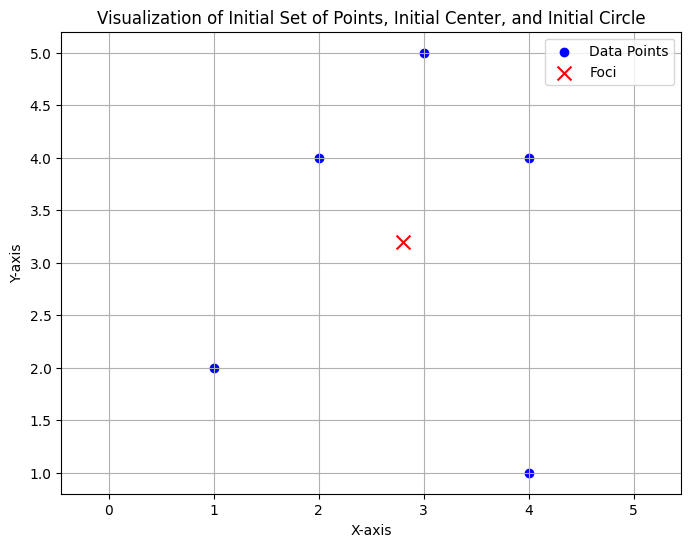

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.31450326818611485
        x: [ 2.914e+00  2.625e+00  1.950e+00]
      nit: 8
      jac: [ 2.831e-07  9.984e-07  1.248e-06]
 hess_inv: [[ 2.678e-01  7.936e-03  1.530e-02]
            [ 7.936e-03  1.922e-01 -5.828e-02]
            [ 1.530e-02 -5.828e-02  1.153e-01]]
     nfev: 44
     njev: 11
optimize
1.9496311658798238 [[2.9141636 2.6247361]]
1.9141636039999441 3.914163603999944
1.6247361040596182 3.624736104059618


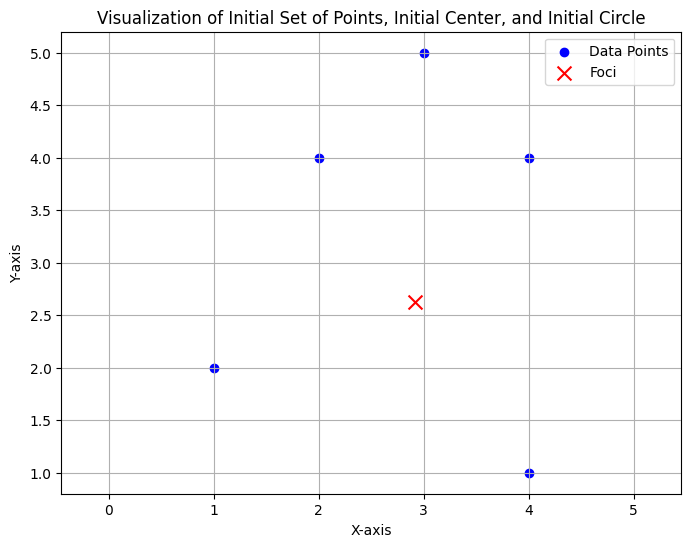

multiply 0
3.8992623317596475 [[2.9141636 2.6247361]
 [2.9141636 2.6247361]]
1.9141636039999441 3.914163603999944
1.6247361040596182 3.624736104059618


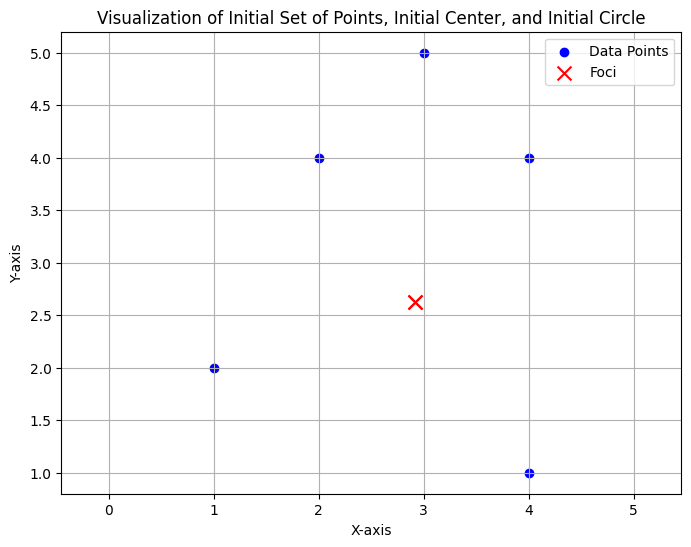

move 0
3.742842602818235 [[3.0141636 2.6247361]
 [2.8141636 2.6247361]]
1.814163603999944 4.014163603999944
1.6247361040596182 3.624736104059618


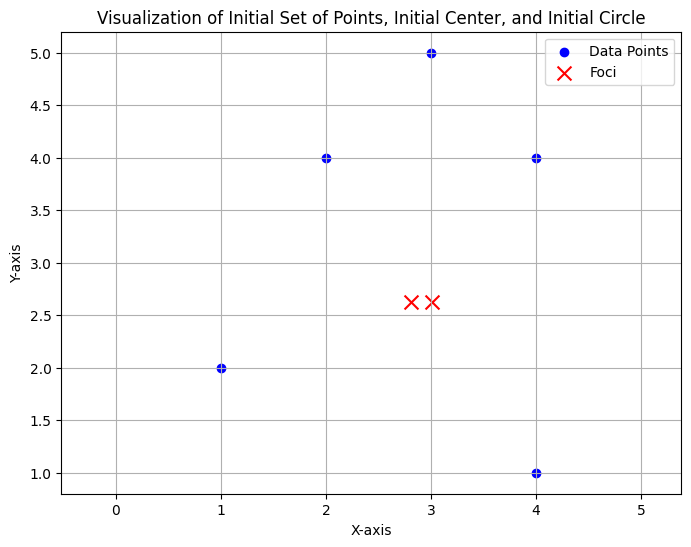

optimize: 0
total_error: 6.72492285361027e-12
12.635403609523827 [[ 3.29823593  4.79811853]
 [ 0.384635   -6.99341293]]
-0.6153650025650188 4.298235927828948
-7.993412928111822 5.7981185349212545


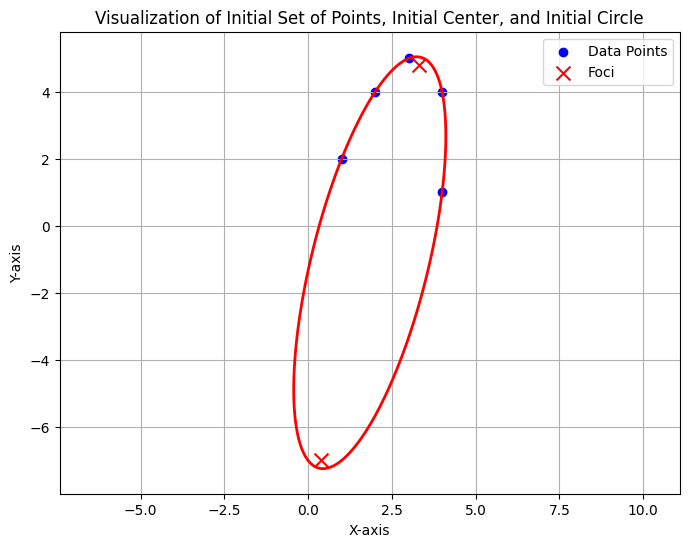

([array([3.29823593, 4.79811853]), array([ 0.384635  , -6.99341293])],
 12.635403609523827)

In [94]:
# Example input points
points = np.array([
    [1.0, 2.0],
    [2.0, 4.0],
    [3.0, 5.0],
    [4.0, 4.0],
    [4.0, 1.0],
    # Add more points as needed
])

approximate_lemniscate(points)